In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.pipeline import Pipeline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/consumer_complaints/Consumer_Complaints.csv


In [2]:
import pandas as pd
complains = pd.read_csv("../input/consumer_complaints/Consumer_Complaints.csv",parse_dates = True,low_memory = False)

In [3]:
complains.groupby('State').sum()

,Complaint ID,Unnamed: 18
State,,
AA,40650003,0.0
AE,670207610,0.0
AK,1898568504,0.0
AL,19971388832,0.0
AP,455154310,0.0
...,...,...
VT,2183575938,0.0
WA,33102325325,0.0
WI,17248350295,0.0


In [4]:
complains['complains_true'] = complains['Consumer Complaint'].apply(lambda x : 0 if pd.isna(x) else 1)

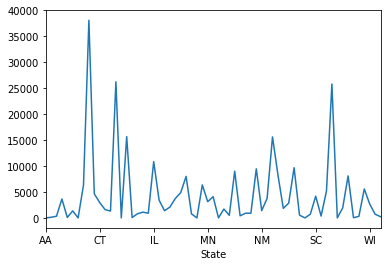

In [5]:
complains.groupby('State').sum()['complains_true'].plot()

In [6]:
complains.groupby('Company').sum()['complains_true'].sort_values(ascending = False)[:10]

Company
EQUIFAX, INC.                             26591
TRANSUNION INTERMEDIATE HOLDINGS, INC.    20952
Experian Information Solutions Inc.       20843
WELLS FARGO & COMPANY                     11009
BANK OF AMERICA, NATIONAL ASSOCIATION     10580
CITIBANK, N.A.                            10412
Navient Solutions, LLC.                    9689
JPMORGAN CHASE & CO.                       9484
CAPITAL ONE FINANCIAL CORPORATION          6587
SYNCHRONY FINANCIAL                        4936
Name: complains_true, dtype: int64

In [7]:
np.random.seed(10)
remove_n = 1000000
drop_indices = np.random.choice(complains.index, remove_n, replace=False)
df = complains.drop(drop_indices)
df.shape
# Remove above code after mem optimization
df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer Complaint,Company Public Response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date Sent to Company,Company Response to Consumer,Timely response?,Consumer disputed?,Complaint ID,Unnamed: 18,complains_true
10,04/14/2017,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,Company believes it acted appropriately as aut...,"Shellpoint Partners, LLC",CA,90305,NaN,NaN,Referral,04/14/2017,Closed with explanation,Yes,No,2436165,NaN,0
19,03-09-2016,Credit reporting,NaN,Incorrect information on credit report,Information is not mine,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,92703,NaN,NaN,Phone,03-09-2016,Closed with explanation,Yes,No,1823789,NaN,0
21,03/17/2017,Bank account or service,Checking account,"Making/receiving payments, sending money",NaN,NaN,Company believes it acted appropriately as aut...,UNITED SERVICES AUTOMOBILE ASSOCIATION,WI,54005,NaN,NaN,Referral,03/20/2017,Closed with explanation,Yes,No,2393048,NaN,0
24,02/25/2014,Debt collection,"Other (i.e. phone, health club, etc.)",Cont'd attempts collect debt not owed,Debt is not mine,NaN,NaN,"Navient Solutions, LLC.",RI,2906,NaN,NaN,Web,02/24/2014,Closed with explanation,Yes,Yes,730165,NaN,0
88,04/18/2017,Student loan,Non-federal student loan,Can't repay my loan,Can't decrease my monthly payments,NaN,NaN,JPMORGAN CHASE & CO.,MD,20772,NaN,NaN,Referral,04/19/2017,Closed with explanation,Yes,No,2439594,NaN,0


In [8]:
df = df[['Product','Consumer Complaint']]
df = df[pd.notnull(df['Consumer Complaint'])]
#pd.notnull(df['Consumer Complaint'])

In [9]:
df['category_id'] = df['Product'].factorize()[0]

In [10]:
category_to_id = dict(df[['Product','category_id']].drop_duplicates().values)

In [11]:
id_to_category = dict(df[['category_id','Product']].drop_duplicates().values)

In [12]:
df.groupby('Product').count()['Consumer Complaint'].sort_values(ascending = False)

Product
Debt collection                                                                 1547
Credit reporting, credit repair services, or other personal consumer reports    1197
Mortgage                                                                        1045
Credit reporting                                                                 735
Credit card                                                                      482
Student loan                                                                     435
Bank account or service                                                          382
Credit card or prepaid card                                                      263
Consumer Loan                                                                    206
Checking or savings account                                                      178
Money transfer, virtual currency, or money service                                73
Vehicle loan or lease                                    

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf = True,min_df = 5,norm = 'l2',encoding = 'latin-1',ngram_range = (1,2),stop_words = 'english')
features = tfidf.fit_transform(df['Consumer Complaint'])
labels = df['category_id']

In [14]:
from sklearn.feature_selection import chi2
for Product,category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features,labels == category_id)
    index = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[index]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print(Product)
    print('most correlated unigrams-->',' '.join(unigrams[-2:]))
    print('most correlated bigrams-->',' '.join(bigrams[-2:]))

Bank account or service
most correlated unigrams--> bank overdraft
most correlated bigrams--> checking account overdraft fees
Checking or savings account
most correlated unigrams--> bonus deposit
most correlated bigrams--> checking account 00 bonus
Consumer Loan
most correlated unigrams--> car vehicle
most correlated bigrams--> hyundai motor purchased vehicle
Credit card
most correlated unigrams--> macy card
most correlated bigrams--> american express credit card
Credit card or prepaid card
most correlated unigrams--> rewards card
most correlated bigrams--> credit card cash advances
Credit reporting
most correlated unigrams--> equifax experian
most correlated bigrams--> credit file credit report
Credit reporting, credit repair services, or other personal consumer reports
most correlated unigrams--> breach equifax
most correlated bigrams--> security breach credit report
Debt collection
most correlated unigrams--> collection debt
most correlated bigrams--> collection agency collect debt


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [16]:
X_train,X_test,y_train,y_test = train_test_split(df['Consumer Complaint'],df['category_id'],test_size = 0.2)
count_vec = CountVectorizer()
X_train_count = count_vec.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_count)
naive_bays = MultinomialNB()
clf = naive_bays.fit(X_train_tfidf,y_train)

In [17]:
clf.predict(tfidf_transformer.transform(count_vec.transform(["This company refuses to provide me verification and validation of debt per my right under the FDCPA. I do not believe this debt is mine."])))

array([0])

In [18]:
clf.predict(tfidf_transformer.transform(count_vec.transform(["I am disputing the inaccurate information the Chex-Systems has on my credit report. I initially submitted a police report on XXXX/XXXX/16 and Chex Systems only deleted the items that I mentioned in the letter and not all the items that were actually listed on the police report. In other words they wanted me to say word for word to them what items were fraudulent. The total disregard of the police report and what accounts that it states that are fraudulent. If they just had paid a little closer attention to the police report I would not been in this position now and they would n't have to research once again. I would like the reported information to be removed : XXXX XXXX XXXX"])))

array([0])

In [19]:
# testing with other classifiers with help of cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
models = [RandomForestClassifier(n_estimators = 200,max_depth = 5),
          LogisticRegression(max_iter = 500),
          LinearSVC(),
          MultinomialNB()
         ]
array = []
for model in  models:
    scores = cross_val_score(model,features,labels,cv=5,verbose = 10,n_jobs = -1)
    for cv_num,scores in enumerate(scores):
        model_name = model.__class__.__name__
        array.append((model_name,cv_num,scores))
        score_df = pd.DataFrame(array,columns = ['model_name','cv_name','scores'])
        
    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.0s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.1s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   19.9s remaining:   29.9s
[Parallel(n_j

In [20]:
score_df

,model_name,cv_name,scores
0,RandomForestClassifier,0,0.384786
1,RandomForestClassifier,1,0.378877
2,RandomForestClassifier,2,0.358198
3,RandomForestClassifier,3,0.396603
4,RandomForestClassifier,4,0.380636
5,LogisticRegression,0,0.655835
6,LogisticRegression,1,0.673560
7,LogisticRegression,2,0.673560
8,LogisticRegression,3,0.652880
9,LogisticRegression,4,0.655580


In [21]:
X_train,X_test,y_train,y_test = train_test_split(features,labels,test_size = 0.2)

In [22]:
clf = LinearSVC(C = 0.6)
classifier = clf.fit(X_train,y_train)
pred = classifier.predict(X_test)

In [23]:
from sklearn.metrics import classification_report
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

           0       0.84      0.71      0.77       342
           1       0.45      0.62      0.52       115
           2       0.80      0.61      0.69       112
           3       0.62      0.62      0.62        99
           4       0.21      0.23      0.22        22
           5       0.12      0.50      0.20         2
           6       0.85      0.78      0.81        89
           7       0.40      0.67      0.50         3
           8       0.96      0.85      0.90       264
           9       0.69      0.82      0.75        11
          10       0.17      1.00      0.29         1
          11       0.12      0.62      0.21         8
          12       0.67      0.58      0.62       268
          14       0.09      1.00      0.17         1
          15       0.11      0.35      0.16        17
          16       0.00      0.00      0.00         0

    accuracy                           0.68      1354
   macro avg       0.44   

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
import sklearn
sklearn.metrics.confusion_matrix(pred,y_test)

array([[242,  23,   4,  15,   7,   4,   3,   1,   6,   0,   2,   2,  25,
          2,   4,   2],
       [  8,  71,   0,   3,   2,   0,   0,   0,   0,   0,   0,   1,  28,
          0,   2,   0],
       [  1,   0,  68,   3,   0,   0,   1,   1,   0,   4,   1,  26,   2,
          1,   3,   1],
       [  3,   0,   2,  61,   0,   0,   0,   0,   0,   0,   1,   0,   4,
          0,  28,   0],
       [  2,   0,   1,   0,   5,   0,   0,   0,   1,   0,   0,   0,   2,
          3,   1,   7],
       [  0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,   0,
          1,   0,   0],
       [  7,   2,   0,   0,   1,   1,  69,   0,   1,   0,   0,   1,   6,
          0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0,   2,   0,   0,   0,   0,   0,
          0,   1,   0],
       [ 10,   3,   4,   1,   4,   1,   4,   0, 225,   0,   0,   2,   7,
          1,   1,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   9,   0,   2,   0,
          0,   0,   0],
       [  0,   0,   0,   0,   

In [25]:
model = LinearSVC(C = 0.6)
model.fit(features,labels)
for Product,category_id in sorted(category_to_id.items()):
    indices = np.argsort(model.coef_[category_id])  # in this line when the model is trained we are sorting the coefficients of the model according to the category
    # and the value we get after applying the argsort is the weights distributed in ascenging order with terms with highest weight at the end of the array
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1][-2:]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2][-2:]
    print(Product)
    print('Unigrams with highest weight for the category ',Product, 'are',unigrams)
    print('bigrams with highest weight for the category ',Product, 'are',bigrams,'\n')

Bank account or service
Unigrams with highest weight for the category  Bank account or service are ['branch', 'bank']
bigrams with highest weight for the category  Bank account or service are ['checking account', 'business account'] 

Checking or savings account
Unigrams with highest weight for the category  Checking or savings account are ['deposit', 'app']
bigrams with highest weight for the category  Checking or savings account are ['00 bonus', 'opened accounts'] 

Consumer Loan
Unigrams with highest weight for the category  Consumer Loan are ['finance', 'vehicle']
bigrams with highest weight for the category  Consumer Loan are ['purchased vehicle', 'auto loan'] 

Credit card
Unigrams with highest weight for the category  Credit card are ['macy', 'card']
bigrams with highest weight for the category  Credit card are ['credit limit', 'credit card'] 

Credit card or prepaid card
Unigrams with highest weight for the category  Credit card or prepaid card are ['capital', 'card']
bigrams w

In [26]:
indices

array([18085, 19202,  3975, ...,  9083, 11843, 14497])

In [27]:
np.array(tfidf.get_feature_names())[np.argsort(model.coef_[0])]

array(['equifax', 'transunion', 'mortgage', ..., 'owe', 'collection',
       'debt'], dtype='<U27')